In [1]:
import sys
sys.path.append('../..')
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import cuda
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.models.mobilenet import mobilenet_v2

# DLBio and own scripts
from DLBio.pytorch_helpers import get_device
import ds_ear_siamese
import transforms_data as td
from helpers import cuda_conv
import metrics as M
from siamese_network_train import Training
from ContrastiveLossFunction import ContrastiveLoss
from NN_Siamese import SiameseNetwork

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(epochs, value1, value2, label1, label2, plt_number):
    plt.figure(plt_number)
    plt.plot(epochs,value1, label=label1)
    plt.plot(epochs,value2, label=label2)
    plt.legend()
    plt.grid()

In [3]:
# Set Up All Configurations here
class Config():
    #1. Boolean ändern
    #2. FC-Layer auf Bild anpassen
    #3. LR auf 0,0005
    NN_SIAMESE = False
    dataset_dir = '../dataset/'
    training_dir = "../data/ears/train/"
    testing_dir = "../data/ears/test/"
    train_batch_size = 32
    val_batch_size = 32
    test_batch_size = 32
    vis_batch_size = 8
    num_workers = 3
    
    EPOCHS= 50
    LEARNINGRATE = 0.0001
    #WEIGHT_DECAY = 0.0

    TRESHOLD_VER = 1.0
    a = 0

In [4]:
# define indicies to split Data
N = len(ds_ear_siamese.get_dataset(data_path=Config.dataset_dir, transform_mode='size_only'))
print(N)
n_80 = int(round(.8*N))
n_70 = int(round(.7*N))
n_60 = int(round(.6*N))
n_20 = int(round(.2*N))
n_10 = int(round(.1*N))

rand_indices = np.random.permutation(N)
train_indices = rand_indices[:n_60]
val_indices = rand_indices[n_60:n_60+n_20]
test_indices = rand_indices[n_60+n_20:]


# definde data loader
# dl_train = ds_ear_siamese.get_dataloader(
train_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.training_dir,
    indices=None,
    batch_size=Config.train_batch_size,
    num_workers=Config.num_workers,
    transform_mode='train', # TODO switch to another transform?
    should_invert = False
)

val_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.testing_dir,
    indices=None,
    batch_size=Config.val_batch_size,
    num_workers=Config.num_workers,
    transform_mode='valid_and_test',
    should_invert = False
)
# dl_test = ds_ear_siamese.get_dataloader(
test_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.testing_dir,
    indices=None,
    batch_size=Config.test_batch_size,
    num_workers=Config.num_workers,
    transform_mode='valid_and_test',
    should_invert = False
)

vis_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.training_dir,
    indices=None,
    batch_size=Config.vis_batch_size,
    num_workers=Config.num_workers,
    transform_mode='train',
    should_invert = False
)

['alexander_bec', 'alina_sch', 'alissa_buh', 'beatrix_mah', 'clara_pau', 'clemens_blu', 'collin_sch', 'david_fau', 'falco_len', 'felix_mec', 'gregor_spi', 'hammam_als', 'janna_qua', 'jesse_kru', 'jule_dre', 'konrad_von', 'lars_fin', 'marcel_nim', 'marina_fri', 'mila_wol', 'mohammed_muh', 'moritz_bor', 'nils_loo', 'robert_kle', 'sarah_feh', 'tim_moe', 'yannik_obe']
2160


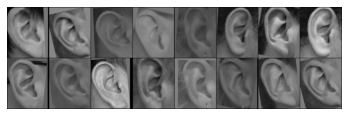

[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [5]:
# visualize some data....
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(make_grid(concatenated))
print(example_batch[2].numpy())

In [6]:
# Definde Model and load to device
if Config.NN_SIAMESE == False:
    model = mobilenet_v2(pretrained=True)
    #model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    #model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=100)
    
    # layers = []
    
    # for layer in model.features[0]:
    #     layers.append(layer)
    # model.features[0][0] = nn.ReflectionPad2d(1)
    # model.features[0][1] = layers[0]
    # model.features[0][2] = layers[1]
    # model.features[0].add_module('3', layers[2])

    #list(model.features[2].children())[0].add_module('4', nn.Dropout2d(0.4))
    #list(model.features[3].children())[0].add_module('4', nn.Dropout2d(0.4))
    #list(model.features[6].children())[0].add_module('4', nn.Dropout2d(0.4))
    #list(model.features[8].children())[0].add_module('4', nn.Dropout2d(0.4))
    #list(model.features[10].children())[0].add_module('4', nn.Dropout2d(0.4))
    #list(model.features[12].children())[0].add_module('4', nn.Dropout2d(0.4))
    #list(model.features[14].children())[0].add_module('4', nn.Dropout2d(0.4))
    #list(model.features[16].children())[0].add_module('4', nn.Dropout2d(0.4))
    model.classifier = nn.Sequential(*list(model.classifier.children())[:-2])



else:
    model = SiameseNetwork()


device = get_device()
print(device)
model.to(device)

contrastive_loss_siamese = ContrastiveLoss(2.0)
optimizer_siamese = torch.optim.Adam(model.parameters(),lr = Config.LEARNINGRATE)

cuda:0


In [7]:
#To Define which Layers we want to train
# for param in model.parameters():
#     param.requires_grad = False

# layers = list(model.children())[0]
# sub_layer = list(layers.children())
# unfreezed = [15,16,17,18]
# for u in unfreezed:
#     for param in sub_layer[u].parameters():
#         param.requires_grad = True

In [8]:
# To show trainable parameters
from DLBio.pytorch_helpers import get_num_params

get_num_params(model,True)

2223872

In [9]:
training = Training(model=model, optimizer=optimizer_siamese,train_dataloader=train_dataloader, val_dataloader=val_dataloader, loss_contrastive=contrastive_loss_siamese, nn_Siamese=Config.NN_SIAMESE, THRESHOLD=Config.TRESHOLD_VER)

epochs, loss_history, val_loss_history, acc_history, val_acc_history = training(Config.EPOCHS)
show_plot(epochs, loss_history, val_loss_history,'train_loss', 'val_loss',1)
show_plot(epochs, acc_history, val_acc_history,'train_acc', 'val_acc', 2)

Epoch number 0
 Current loss 55.6243
 Current acc 50.94
 Current val_loss 10.5680
 Current val_acc 50.69

Epoch number 1
 Current loss 4.8013
 Current acc 50.00
 Current val_loss 1.9934
 Current val_acc 54.69

Epoch number 2
 Current loss 1.6375
 Current acc 51.69
 Current val_loss 1.3081
 Current val_acc 54.34



FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/nfshome/lentzsch/.virtualenvs/Bachelorthesis/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/nfshome/lentzsch/.virtualenvs/Bachelorthesis/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/nfshome/lentzsch/.virtualenvs/Bachelorthesis/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/nfshome/lentzsch/Documents/Bachelorarbeit/Bachelorthesis/siamese_network_dataset.py", line 45, in __getitem__
    img0 = Image.open(img0_tuple[0])
  File "/nfshome/lentzsch/.virtualenvs/Bachelorthesis/lib/python3.7/site-packages/PIL/Image.py", line 2843, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '../data/ears/train/moritz_bor/moritz_bor001png.png'


In [10]:
# tn Bilder nicht gleich, Distanz größer als THRESH
# fp Bilder nicht gleich, Distanz kleiner als THRESH
# fn Bilder gleich, Distanz größer als THRESH
# tp Bilder gleich, Distanz kleiner als THRESH

ground_truth, prediction = [], []

for data in test_dataloader:
    # use training class for data extraction
    label, output1, output2 = training.get_label_outputs(data)
    # extend labels of the ground truth
    ground_truth.extend(label.flatten().tolist())
    # Extend the distance-threshold prediction
    prediction.extend(M.batch_predictions_bin(output1, output2, Config.TRESHOLD_VER))


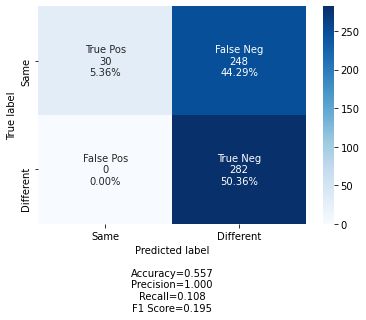

In [11]:
# Set parameters for confusion_matrix plot
cf = M.cf_matrix(ground_truth, prediction)
labels = ['True Pos','False Neg','False Pos','True Neg']
categories = ['Same', 'Different']

# plot matrix
M.make_confusion_matrix(cf,
                        group_names=labels,
                        categories=categories,
                        cbar=True
                        )

In [12]:
#model = torch.load('/Users/falcolentzsch/Develope/Bachelorthesis/Bachelorthesis/models/model.pt')

In [13]:
#torch.save(model,'/nfshome/lentzsch/Documents/Bachelorarbeit/Bachelorthesis/models/model_MN_allunfreezed.pt')